# Example notebook continuous calibration

In this notebook, the use of the CP classes for continuous calibration are demonstrated. As example dataset, the ChEMBL dataset used in the manuscript for endpoint "CHEMBL228" is loaded. You can also exchange it with your own data.

### Import packages and modules

In [1]:
import pandas as pd
import numpy as np
import sys
import tarfile

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor

In [3]:
from nonconformist.nc import InverseProbabilityErrFunc, NcFactory

In [4]:
from continuous_calibration import (
StratifiedRatioSampler, BalancedStratifiedRatioSampler, CrossValidationSampler, InductiveConformalPredictor, 
    ContinuousCalibrationAggregatedConformalPredictor, CrossValidator
)
from continuous_calibration_helper_functions import draw_scatter_plot_one_endpoint, create_umap_data, plot_umap

### Define paths and parameters

In [5]:
data_path = "../data/chembl_chembio_descriptors.tar.bz2"
time_split_threshold_path = "../data/data_size_chembio_chembl.csv"

In [6]:
endpoint = "CHEMBL228"

In [7]:
ntrees = 50  # 500
n_folds_acp = 3  # 20

ratio_sampler = StratifiedRatioSampler(n_folds=n_folds_acp)

### Load data

In [8]:
# Due to the size of the datasets containing the chembio descriptors, 
# they were uploaded to GitHub as tar.bz2 files and need to be unpacked first
tar = tarfile.open(data_path)

In [9]:
# The data is collected in the `files` dict, containing as keys the ChEMBL endpoint name and as value the dataframe
files = {}
for i, name in zip(tar, tar.getnames()):
    file = tar.extractfile(i)
    if file:  # Extraction also yields an empty folder (?) which will be ignored
        n = name.split("/")[1].split('_')[0]  # Get ChEMBL endpoint name from filename
        if n == endpoint:
            print(n)
            df = pd.read_csv(file)  # Read df
            files[n] = df  # Store in dict

CHEMBL228


In [10]:
# Select a specific example dataset
data = files[endpoint]
data.dropna(subset=["year"], inplace=True)

In [11]:
# Define labels
y = data[f"{endpoint}_bioactivity"].values
y

array([0, 0, 0, ..., 1, 1, 1])

In [12]:
# Define features (p-values and chemical descriptors)
columns = [col for col in data.columns if col.startswith('p') or col.startswith('byte')]
X = data[columns].values
X

array([[-0.20278679, -0.8864429 , -0.64854513, ...,  0.16953868,
        -0.77970748,  0.79482231],
       [-0.28295224,  0.26077434, -0.64854513, ...,  0.22767178,
        -0.88450568,  1.35093976],
       [-0.25159849,  0.26077434, -0.64854513, ...,  1.27806444,
        -0.8843573 ,  1.21098428],
       ...,
       [-1.11368145, -0.8864429 , -0.64854513, ..., -0.77273345,
         1.32371173, -1.3983778 ],
       [-0.17143304, -0.8864429 ,  2.04678629, ..., -2.01146873,
         0.25305191, -0.58964739],
       [-0.17143304,  0.28045739, -0.64854513, ..., -1.4576498 ,
         1.71728142, -1.53578739]])

In [13]:
years = data["year"].values
years

array([2011., 2018., 2016., ..., 2018., 2009., 2014.])

In [14]:
# Define UMAP parameters
descriptors = "chembio"
n_neighbors = 100
min_distances = 0.8
distance_metric = "euclidean"
umap_colours = ["navy", "magenta", "orangered", "green"]

### Split data

#### Load dataframe defining time-split thresholds per endpoint

In [15]:
splits_df = pd.read_csv(time_split_threshold_path, index_col=0, 
                        usecols=["chembl_id", "train_thresh", "update1_thresh", "update2_thresh"])
splits_df

,train_thresh,update1_thresh,update2_thresh
chembl_id,,,
CHEMBL220,2014,2016,2017
CHEMBL4078,2014,2015,2016
CHEMBL5763,2015,2016,2017
CHEMBL203,2012,2014,2016
CHEMBL206,2006,2012,2016
CHEMBL279,2010,2013,2014
CHEMBL230,2010,2013,2015
CHEMBL340,2012,2014,2015
CHEMBL240,2012,2014,2016


In [16]:
splits_df.index

Index(['CHEMBL220', 'CHEMBL4078', 'CHEMBL5763', 'CHEMBL203', 'CHEMBL206',
       'CHEMBL279', 'CHEMBL230', 'CHEMBL340', 'CHEMBL240', 'CHEMBL2039',
       'CHEMBL222', 'CHEMBL228'],
      dtype='object', name='chembl_id')

In [17]:
# Get year thresholds for selected endpoint
thresholds = splits_df["train_thresh"][endpoint], splits_df["update1_thresh"][endpoint], splits_df["update2_thresh"][endpoint]
thresholds

(2009, 2011, 2014)

In [18]:
mask_train = years <= thresholds[0]
mask_update1 = (years > thresholds[0]) & (years <= thresholds[1])
mask_update2 = (years > thresholds[1]) & (years <= thresholds[2])
mask_holdout = years > thresholds[2]

X_train, y_train = X[mask_train], y[mask_train]
X_update1, y_update1 = X[mask_update1], y[mask_update1]
X_update2, y_update2 = X[mask_update2], y[mask_update2]
X_holdout, y_holdout = X[mask_holdout], y[mask_holdout]

In [19]:
# Check len of arrays
print(f"Training set shape: y={y_train.shape}, X={X_train.shape}")
print(f"Update1 set shape: y={y_update1.shape}, X={X_update1.shape}")
print(f"Update2 set shape: y={y_update2.shape}, X={X_update2.shape}")
print(f"Holdout set shape: y={y_holdout.shape}, X={X_holdout.shape}")

# Check if we have actives and inactives in all datasets
print(f"# Active compounds training set: {y_train.sum()},")
print(f"update1 set: {y_update1.sum()}, update2 set: {y_update2.sum()}, holdout set: {y_holdout.sum()}")

Training set shape: y=(1100,), X=(1100, 2241)
Update1 set shape: y=(470,), X=(470, 2241)
Update2 set shape: y=(266,), X=(266, 2241)
Holdout set shape: y=(275,), X=(275, 2241)
# Active compounds training set: 858,
update1 set: 373, update2 set: 235, holdout set: 196


### Prepare the ACP

In [20]:
clf = RandomForestClassifier(n_estimators=ntrees)
error_function = InverseProbabilityErrFunc()
nc = NcFactory.create_nc(
        clf, err_func=error_function, normalizer_model=None
    )
icp = InductiveConformalPredictor(
        nc_function=nc, smoothing=False, condition=(lambda instance: instance[1])
    )  # Mondrian as (default) condition)

In [21]:
acp = ContinuousCalibrationAggregatedConformalPredictor(predictor=icp, sampler=ratio_sampler,
        aggregation_func=np.median
    )

### Fit and calibrate the model, make predictions
Calibrate with the `original` calibration set, which is a split from X_train/y_train

In [22]:
acp.fit_calibrate(X_train=X_train, y_train=y_train)

In [23]:
original_prediction = acp.predict(X_score=X_holdout)

original_prediction[:5]

array([[0.35135135, 0.0620155 ],
       [0.2972973 , 0.0620155 ],
       [0.40540541, 0.04263566],
       [0.18918919, 0.10077519],
       [0.14864865, 0.13953488]])

### Update calibration set
Calibrate the fitted (not yet calibrated) predictors with a 'new' dataset

In [24]:
# Check that no `calibrated update` predictor yet
print(acp.predictors_calibrated_update)

{}


In [25]:
acp.calibrate_update(X_update=X_update1, y_update=y_update1)

1

In [26]:
# Make predictions with the model and the updated calibration set
calibrate_update_prediction = acp.predict_calibrate_update(updated_number=1, X_score=X_holdout)
calibrate_update_prediction[:5]

array([[0.82653061, 0.02941176],
       [0.66326531, 0.10427807],
       [0.80612245, 0.03475936],
       [0.55102041, 0.14438503],
       [0.32653061, 0.37700535]])

### New calibration
We can update with an even 'newer' calibration set (as often as we want). The model with the updated calibration set will be saved in the acp object.

In [27]:
# Check how many updated calibration sets we already have. Here, this should be 1
print(acp.predictors_calibrated_update.keys())

dict_keys(['update_1'])


In [28]:
acp.calibrate_update(X_update=X_update2, y_update=y_update2)

2

In [29]:
calibrate_update_2_predcition = acp.predict_calibrate_update(updated_number=2, X_score=X_holdout)
calibrate_update_2_predcition[:5]

array([[0.9375    , 0.02966102],
       [0.84375   , 0.05084746],
       [0.9375    , 0.01271186],
       [0.6875    , 0.0720339 ],
       [0.375     , 0.19491525]])

### Perform continuous calibration within crossvalidation
Instead of using the individual acp's, we might want to include everything into a crossvalidator. 
Advantages: 
* Splitting of cv into test and train set are handled
* Fixed and reproducible pipeline (except for random splitting and random forest)
* We can automatically create a calibration plot
* Updating of the same trained models possible

Note that we use fivefold cv by default

In [30]:
cv_acp = ContinuousCalibrationAggregatedConformalPredictor(predictor=icp, sampler=ratio_sampler,
        aggregation_func=np.median
    )
cross_validator = CrossValidator(predictor=cv_acp, cv_splitter=CrossValidationSampler())

In [31]:
# Crossvalidate with the "original" training set (no update calibration set)
cv_eval_df = cross_validator.cross_validate(X_train=X_train, y_train=y_train, X_score=X_holdout, y_score=y_holdout, steps=10, endpoint=endpoint)

In [32]:
# Look at evaluation per cv fold
cv_eval_df[["validity", "efficiency", "accuracy", "significance_level", "fold"]].set_index("fold").head()

,validity,efficiency,accuracy,significance_level
fold,,,,
0,1.000,0.000,0.000,0.0
0,0.941,0.836,0.929,0.1
0,0.845,0.964,0.873,0.2
0,0.777,0.836,0.929,0.3
0,0.695,0.723,0.962,0.4


In [33]:
# Look at averaged (all folds) evaluations
cross_validator.averaged_evaluation_df_cv[["validity mean", "efficiency mean", "accuracy mean", "significance_level"]]

,validity mean,efficiency mean,accuracy mean,significance_level
significance_level,,,,
0.0,1.0000,0.0000,0.0000,0.0
0.1,0.9228,0.8282,0.9076,0.1
0.2,0.8162,0.9364,0.8706,0.2
0.3,0.7472,0.8162,0.9150,0.3
0.4,0.6618,0.7102,0.9316,0.4
0.5,0.5508,0.5810,0.9480,0.5
0.6,0.4500,0.4736,0.9502,0.6
0.7,0.3544,0.3692,0.9614,0.7
0.8,0.2352,0.2418,0.9734,0.8


In [34]:
cross_validator.averaged_evaluation_df_cv[["validity_bal mean", "efficiency_bal mean", "accuracy_bal mean", "significance_level"]]

,validity_bal mean,efficiency_bal mean,accuracy_bal mean,significance_level
significance_level,,,,
0.0,1.0000,0.0000,0.0000,0.0
0.1,0.9325,0.8336,0.9204,0.1
0.2,0.8228,0.9443,0.8714,0.2
0.3,0.7534,0.8171,0.9227,0.3
0.4,0.6659,0.7072,0.9405,0.4
0.5,0.5533,0.5786,0.9559,0.5
0.6,0.4530,0.4742,0.9552,0.6
0.7,0.3502,0.3640,0.9614,0.7
0.8,0.2262,0.2319,0.9736,0.8


The predictions are saved in a dictionary that contains the information for the predictions within the crossvalidation and the predictions for the score set. The predictions (values) are in the form of a list, list elements are the predicted p-values and the known labels. 

In [35]:
print("keys: ", cross_validator._predictions.keys(), "\n")
print("p-values: ", cross_validator._predictions["pred_score"][0][0][:5], "\n")
# [0]: predictions, [0]: first loop of cv, [:5]: first five p-values
print("labels: ", cross_validator._predictions["pred_score"][1])
# [1]: labels

keys:  dict_keys(['cv', 'pred_score']) 

p-values:  [[0.30508475 0.09661836]
 [0.3220339  0.10144928]
 [0.28813559 0.13043478]
 [0.28813559 0.11111111]
 [0.28813559 0.10628019]] 

labels:  [[0 0 1 ... 0 0 1]
 [0 0 1 ... 0 0 1]
 [0 0 1 ... 0 0 1]
 [0 0 1 ... 0 0 1]
 [0 0 1 ... 0 0 1]]


In [36]:
# Look at evaluation df for cross validation (averaged over all folds)
cross_validator.averaged_evaluation_df_cv

,validity mean,validity std,validity_0 mean,validity_0 std,validity_1 mean,validity_1 std,validity_bal mean,validity_bal std,error_rate mean,error_rate std,...,accuracy std,accuracy_0 mean,accuracy_0 std,accuracy_1 mean,accuracy_1 std,accuracy_bal mean,accuracy_bal std,significance_level,num_actives,num_inactives
significance_level,,,,,,,,,,,,,,,,,,,,,
0.0,1.0000,0.000000,1.0000,0.000000,1.0000,0.000000,1.0000,0.000000,0.0000,0.000000,...,0.000000,0.0000,0.000000,0.0000,0.000000,0.0000,0.000000,0.0,858,242
0.1,0.9228,0.033086,0.9502,0.047934,0.9148,0.043734,0.9325,0.028029,0.0772,0.033086,...,0.033761,0.9428,0.054509,0.8980,0.045908,0.9204,0.028593,0.1,858,242
0.2,0.8162,0.036888,0.8344,0.049803,0.8112,0.051843,0.8228,0.026994,0.1838,0.036888,...,0.024131,0.8722,0.070123,0.8706,0.039972,0.8714,0.026423,0.2,858,242
0.3,0.7472,0.039884,0.7642,0.032614,0.7426,0.044948,0.7534,0.034795,0.2528,0.039884,...,0.036325,0.9358,0.055414,0.9096,0.045070,0.9227,0.034488,0.3,858,242
0.4,0.6618,0.036602,0.6732,0.072275,0.6586,0.054450,0.6659,0.032155,0.3382,0.036602,...,0.027808,0.9574,0.042753,0.9236,0.038824,0.9405,0.021803,0.4,858,242
0.5,0.5508,0.031995,0.5576,0.075794,0.5490,0.060037,0.5533,0.014733,0.4492,0.031995,...,0.032871,0.9712,0.040196,0.9406,0.040476,0.9559,0.029348,0.5,858,242
0.6,0.4500,0.013838,0.4584,0.057735,0.4476,0.021916,0.4530,0.023883,0.5500,0.013838,...,0.019766,0.9644,0.048932,0.9460,0.024166,0.9552,0.024196,0.6,858,242
0.7,0.3544,0.023839,0.3426,0.069576,0.3578,0.041282,0.3502,0.024722,0.6456,0.023839,...,0.024131,0.9628,0.058264,0.9600,0.026391,0.9614,0.031762,0.7,858,242
0.8,0.2352,0.028358,0.2100,0.097880,0.2424,0.020157,0.2262,0.051372,0.7648,0.028358,...,0.010714,0.9750,0.055902,0.9722,0.008643,0.9736,0.027781,0.8,858,242


In [37]:
# Look at evaluation df predicting the score set (averaged over all folds)
cross_validator.averaged_evaluation_df_pred_score[["validity mean", "efficiency mean", "accuracy mean", "significance_level"]]

,validity mean,efficiency mean,accuracy mean,significance_level
significance_level,,,,
0.0,1.0000,0.0000,0.0000,0.0
0.1,0.8398,0.5224,0.6896,0.1
0.2,0.5106,0.8100,0.6296,0.2
0.3,0.2874,0.4034,0.7162,0.3
0.4,0.1586,0.2124,0.7470,0.4
0.5,0.0752,0.1010,0.7366,0.5
0.6,0.0458,0.0554,0.8302,0.6
0.7,0.0284,0.0320,0.8902,0.7
0.8,0.0108,0.0108,0.8000,0.8


### Calibration plots of CV and prediction of score set, using the 'original' calibration set
Note that we can not interpret these plots as results yet as the underlying data is based on just an arbitrary split of one dataset.

The plot shows the mean (line) and standard deviation (area) of the evaluation measures indicated in the legend (expected_error_rate excluded) over the fivefold crossvalidation. 

<module 'matplotlib.pyplot' from '/home/andrea/anaconda2/envs/recalibration_si/lib/python3.8/site-packages/matplotlib/pyplot.py'>

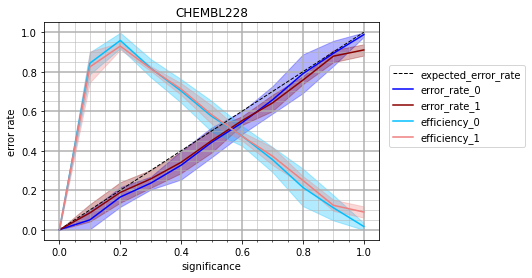

In [38]:
cross_validator.calibration_plot(endpoint=endpoint, averaged_evaluation_df=cross_validator.averaged_evaluation_df_cv)

<module 'matplotlib.pyplot' from '/home/andrea/anaconda2/envs/recalibration_si/lib/python3.8/site-packages/matplotlib/pyplot.py'>

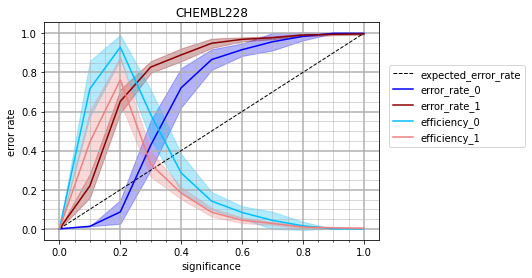

In [39]:
cross_validator.calibration_plot(endpoint=endpoint, averaged_evaluation_df=cross_validator.averaged_evaluation_df_pred_score)

In [40]:
# We would get an assertion error, if we try to plot the calibration plot using the updated calibration set, 
# since we have not updated it yet.
# cross_validator.calibration_plot(endpoint=endpoint, averaged_evaluation_df=cross_validator.averaged_evaluation_df_cal_update_1)

In [41]:
print(len(cross_validator.train_indices[0]))

880


### Update the calibration set within the crossvalidator
Note: here we show the first update step with X_update1/y_update1. We could add one more update step with X_update2/y_update2.

In [42]:
# For control, the 'updated number' is printed, which is the number under which the updated 
# model/predictions are saved. This is important since the number will be incremented
# automatically when another number is already used.
cross_validator.cross_validate_calibrate_update(X_update=X_update1, y_update=y_update1, X_score=X_holdout, y_score=y_holdout, steps=10, endpoint=endpoint)

In [43]:
cross_validator._evaluation_dfs.keys()

dict_keys(['cv', 'pred_score', 'cal_update_1'])

In [44]:
cross_validator._predictions.keys()

dict_keys(['cv', 'pred_score', 'cal_update_1'])

In [45]:
print(len(cross_validator.predictors))

5


In [46]:
# Look at evaluation df predicting the score set using the updated calibration set (averaged over all folds)
cross_validator.averaged_evaluation_df_cal_update_1[["validity mean", "efficiency mean", "accuracy mean", "significance_level"]]

,validity mean,efficiency mean,accuracy mean,significance_level
significance_level,,,,
0.0,1.0000,0.0000,0.0000,0.0
0.1,0.8788,0.4630,0.7380,0.1
0.2,0.7724,0.7760,0.7064,0.2
0.3,0.6690,0.9318,0.6752,0.3
0.4,0.5584,0.8008,0.6980,0.4
0.5,0.4800,0.6570,0.7316,0.5
0.6,0.3900,0.5258,0.7426,0.6
0.7,0.2758,0.3554,0.7794,0.7
0.8,0.1856,0.2400,0.7766,0.8


### Calibration plot for the score set using the updated calibration set

<module 'matplotlib.pyplot' from '/home/andrea/anaconda2/envs/recalibration_si/lib/python3.8/site-packages/matplotlib/pyplot.py'>

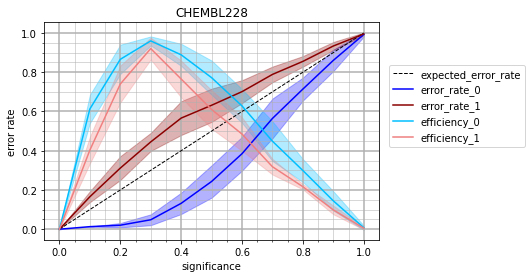

In [47]:
cross_validator.calibration_plot(endpoint=endpoint, averaged_evaluation_df=cross_validator.averaged_evaluation_df_cal_update_1)

In [48]:
strategies = ["cv_original", "original", "update1"]#, "update2"]
eval_df_columns = ["validity_bal mean", "efficiency_bal mean", "accuracy_bal mean", "significance_level"]

In [49]:
evaluation_measures = [m.split(" ")[0] for m in eval_df_columns[:-1]]
print(evaluation_measures)

['validity_bal', 'efficiency_bal', 'accuracy_bal']


In [50]:
evaluation_dfs_dict = {}
evaluation_dfs_dict["cv_original"] = cross_validator.averaged_evaluation_df_cv[eval_df_columns]
evaluation_dfs_dict["original"] = cross_validator.averaged_evaluation_df_pred_score[eval_df_columns]
evaluation_dfs_dict["update1"] = cross_validator.averaged_evaluation_df_cal_update_1[eval_df_columns]
# evaluation_dfs_dict["update2"] = cross_validator.averaged_evaluation_df_cv[eval_df_columns]

In [51]:
from continuous_calibration_helper_functions import draw_scatter_plot_one_endpoint

In [52]:
import matplotlib.pyplot as plt

### Scatter plot to compare different strategies

(<module 'matplotlib.pyplot' from '/home/andrea/anaconda2/envs/recalibration_si/lib/python3.8/site-packages/matplotlib/pyplot.py'>,
 <matplotlib.legend.Legend at 0x7f301ee26c40>)

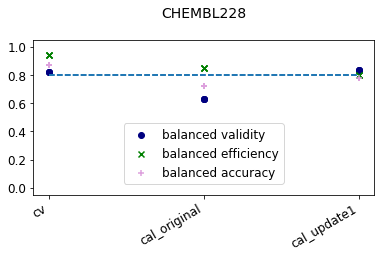

In [53]:
draw_scatter_plot_one_endpoint(endpoint, evaluation_dfs_dict, evaluation_measures=evaluation_measures)

### UMAP to analyse chemical space of subsets

In [56]:
embedding, colours_numbers = create_umap_data(
    chembl_id=endpoint, descriptors_df=data, thresholds=thresholds, n_neighbors=n_neighbors,
    min_distances=min_distances, distance_metric=distance_metric, dataset_colours=umap_colours)

desc chembio


2111


<module 'matplotlib.pyplot' from '/home/andrea/anaconda2/envs/recalibration_si/lib/python3.8/site-packages/matplotlib/pyplot.py'>

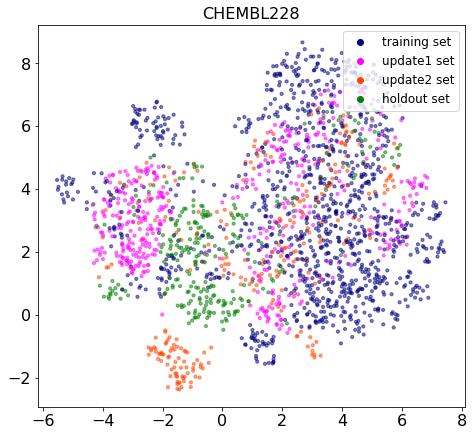

In [58]:
plot_umap(embedding, endpoint, colours_datasets=colours_numbers, umap_colours=umap_colours, n_neighbor=n_neighbors, min_distance=min_distances, distance_metric=distance_metric)